# Predicting Loan Repayment using XGBoost
## Environment and Data

First, we will import the Python libraries needed for this exercise.

We can then load the CSV databases with the training and validation entries.

In [60]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import sort
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.feature_selection import SelectFromModel

pd.set_option('display.float_format', lambda x: '%8.2f' % x)

# Reading the data with ; as separator
train = pd.read_csv('Training.csv', delimiter = ";", decimal = ",")
valid = pd.read_csv('Validation.csv', delimiter = ";", decimal = ",")
total_data = pd.concat([train, valid], axis = 0)
total_data.columns = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','classlabel']

# Checking how many NA values exist
total_data.isnull().sum()

v1              69
v2               0
v3              42
v4               0
v5               0
v6              42
v7               0
v8             103
v9               0
v10              0
v11             66
v12              0
v13              0
v14             69
v15           2256
v16            103
v17              0
v18             66
v19              0
v20              0
v21              0
classlabel       0
dtype: int64

From the above, we notice that only one variable has a significant number of NA values. In fact, `v15` has 2256 NAs out of 3900 entries or **57.85% of total**. In this case, it is safe to ignore this variable moving on. For the rest of them, since the number of NA values is less than 3% of total, we can just drop the lines where we have NA values with the *.dropna()* function.

In [46]:
# Removing v15 for having 58% missing data
total_data = total_data.drop('v15', 1)

# Obtaining data with no NAs
total_data = total_data.dropna()
total_data = total_data.reset_index(drop=True)

# Variable description
summary = total_data.describe()
summary.transpose()


,count,mean,std,min,25%,50%,75%,max
v3,3713.00,32.85,12.49,13.75,22.92,28.92,40.83,76.75
v5,3713.00,3.43,4.34,0.00,0.54,1.75,5.00,28.50
v8,3713.00,164.08,158.78,0.00,0.00,120.00,280.00,2000.00
v9,3713.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
v10,3713.00,4.22,6.77,0.00,0.00,2.00,6.00,67.00
v12,3713.00,3.32,1.00,0.00,2.64,3.32,3.99,6.62
v16,3713.00,1640816.05,1587819.31,0.00,0.00,1200000.00,2800000.00,20000000.00
v17,3713.00,2139.10,8548.36,0.00,0.00,108.00,1000.00,100000.00
v19,3713.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00


In [47]:
# Frequency tables for each categorical variable

features = total_data[['v1', 'v2', 'v4', 'v6', 'v7', 'v11', 'v13', 
                      'v14', 'v18', 'v19', 'v20', 'v21']]
                     
for column in features.columns:     
    display(pd.crosstab(index = features[column], columns='% observations', normalize='columns'))


col_0,% observations
v1,
bb,0.09
dd,0.01
ff,0.04
h,0.27
j,0.01
n,0.01
o,0.00
v,0.55
z,0.01


col_0,% observations
v2,
g,0.94
p,0.00
s,0.05


col_0,% observations
v4,
f,0.09
t,0.91


col_0,% observations
v6,
a,0.35
b,0.65


col_0,% observations
v7,
f,0.39
t,0.61


col_0,% observations
v11,
l,0.01
u,0.83
y,0.16


col_0,% observations
v13,
f,0.50
t,0.50


col_0,% observations
v14,
W,0.10
aa,0.06
c,0.21
cc,0.10
d,0.03
e,0.04
ff,0.04
i,0.06
j,0.01


col_0,% observations
v18,
g,0.83
gg,0.01
p,0.16


col_0,% observations
v19,
0,0.50
1,0.50


col_0,% observations
v20,
f,0.57
t,0.43


col_0,% observations
v21,
f,0.57
t,0.43


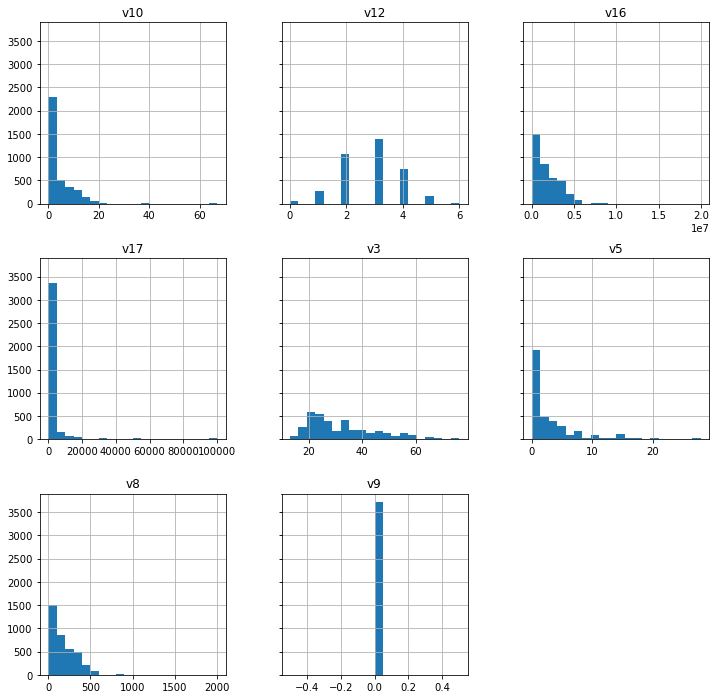

In [48]:
# Histograms for each numeric variable

numeric = total_data[['v3','v5','v8','v9','v10','v12','v16','v17']]
numeric = numeric.astype(int)
numeric.hist(bins=20, sharey=True, figsize=(12, 12))
plt.show()


In [49]:
# Value count for the class label (Y variable)

total_data['classlabel'].value_counts()


yes.    3356
no.      357
Name: classlabel, dtype: int64

In [50]:
# Encoding the classlabel

total_struct = total_data
class_mapping = {label:idx for idx,label in enumerate(np.unique(total_data['classlabel']))}
total_struct['classlabel'] = total_data['classlabel'].map(class_mapping)
total_struct['classlabel'].value_counts()


1    3356
0     357
Name: classlabel, dtype: int64

From the tables above, we can observe the binary distribution of our dependent variable. Thus, we have around 90% Yes values, representing persons that have repaid their loan and about 10% No values, or persons that have defaulted on their loan. These have been encoded with 1 and 0 for ease of computation.

In [61]:
# Export cleaned database to spreadsheet

total_struct.to_csv('kreditech.csv')

## Testing for Correlation between numeric predictors

Before selecting and training a predictive model, we want to test for variable correlation. There are three main reasons to remove highly correlated features:

- *Faster learning algorithm*

Due to the curse of dimensionality, less features usually means high improvement in terms of speed. If speed is not an issue, we don't have to remove these features right away, we can check the following point.

- *Decrease harmful bias*

Some Machine Learning algorithms will build unstable models if two or more highly correlated variables are included in the model, and others will just slow down.

- *Interpretability of the model*

Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions. More generally, this can be viewed as a special case of Occam's razor. A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of minimum description length makes this more precise.

In [51]:
# Testing for variable correlations: correlation matrix and scatter plot

correlation_matrix = numeric.corr()

# Print variables with a correlation factor > 0.9

corr_m = correlation_matrix.unstack().reset_index() # group together pairwise
corr_m.columns = ['var1', 'var2', 'correlation'] # rename columns to something readable
problematic_corr = corr_m[(corr_m['correlation'].abs() > 0.9) & (corr_m['var1'] != corr_m['var2'])]
problematic_corr = problematic_corr.sort_values('correlation', ascending = False)
problematic_corr = problematic_corr.reset_index(drop = True)
problematic_corr['correlation'] = problematic_corr['correlation'].round(2)

print(problematic_corr)


  var1 var2  correlation
0   v8  v16         1.00
1  v16   v8         1.00


Whenever two supposedly independent variables are highly correlated, it will be difficult to assess their relative importance in determining the dependent variable. The higher the correlation between independent variables, the greater the sampling error of the model. High correlation for predictive models is usually defined to be a value above 0.9 (or 90%), therefore, we have to remove one feature for each above pair of correlated variables.

In [52]:
# Drop v16 for being the same as v8 and v9 for having no data variation

features = pd.get_dummies(features)
numeric = numeric.drop(['v16', 'v9'], 1)
Y = total_struct['classlabel']
X = pd.concat([numeric, features], axis=1)   #num.reset_index(drop=True)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3713 entries, 0 to 3712
Data columns (total 51 columns):
v3        3713 non-null int64
v5        3713 non-null int64
v8        3713 non-null int64
v10       3713 non-null int64
v12       3713 non-null int64
v17       3713 non-null int64
v19       3713 non-null int64
v1_bb     3713 non-null uint8
v1_dd     3713 non-null uint8
v1_ff     3713 non-null uint8
v1_h      3713 non-null uint8
v1_j      3713 non-null uint8
v1_n      3713 non-null uint8
v1_o      3713 non-null uint8
v1_v      3713 non-null uint8
v1_z      3713 non-null uint8
v2_g      3713 non-null uint8
v2_p      3713 non-null uint8
v2_s      3713 non-null uint8
v4_f      3713 non-null uint8
v4_t      3713 non-null uint8
v6_a      3713 non-null uint8
v6_b      3713 non-null uint8
v7_f      3713 non-null uint8
v7_t      3713 non-null uint8
v11_l     3713 non-null uint8
v11_u     3713 non-null uint8
v11_y     3713 non-null uint8
v13_f     3713 non-null uint8
v13_t     3713 non-null

As it can be seen above, we have ended up with one dependent variable, `Y` and 51 numeric or dummy predictors to be used as factors in the XGBoost predictive model. The number of records, 3713, is, in fact, the number of distinct customers that we have (one line of data for each user).

## Predictive modeling
We can now begin building the predictive model. The first step is to partition our data into a training and a testing set. The training set will be used to prepare the XGBoost model and the test set will be used to make new predictions, from which we can evaluate the performance of the model.

For this we will use the *train_test_split()* function from the scikit-learn library. The partition will be a 70%-30% split between training and test data. We also specify a seed for the random number generator so that we always get the same partitioning of data each time this example is executed.

In [53]:
# Partition the dataset into training and validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print("Value counts for Y training variable")
print(y_train.value_counts())
print()
print("Value counts for Y test variable")
print(y_test.value_counts())


Value counts for Y training variable
1    2349
0     250
Name: classlabel, dtype: int64

Value counts for Y test variable
1    1007
0     107
Name: classlabel, dtype: int64


From the above, we can observe the split value counts for our dependent variable. In the training set, we have 2349 Repayments or 90.38% of total and 250 Defaults or almost 10% of total. In the validation set, we have 1007 Repayments or 90.39% of total and 107 Defaults or or almost 10% of total.

We are now ready to train our model. XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework. The XGBoost model for classification is called XGBClassifier. We can create and and fit it to our training dataset. Models are fit using the scikit-learn API and the *.fit()* function.
Parameters for training the model can be passed to the model in the constructor. Here, we use the sensible defaults.

In [54]:
# Fit model to training data

model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

The meaning of each parameter and how to configure them can be studied in depth on the XGBoost parameters page: http://xgboost.readthedocs.io/en/latest//parameter.html 

We are now ready to use the XGBoost model for prediction. We can make predictions using the fitted model on the test dataset, by applying the scikit-learn function *.predict()*. By default, the predictions made by the algorithm are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. However, the model automatically rounds this probabilities to 0 and 1, based on a cutoff point with a default value of 0.5.

In [55]:
#Predictions on validation data set

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(accuracy_score(y_test, y_pred, normalize=False), "correct predictions from a total of", len(y_pred))
print()
target_names = ['0 - No', '1 - Yes']
print(classification_report(y_test, y_pred, target_names = target_names))


Accuracy: 97.58%
1087 correct predictions from a total of 1114

             precision    recall  f1-score   support

     0 - No       0.93      0.81      0.87       107
    1 - Yes       0.98      0.99      0.99      1007

avg / total       0.98      0.98      0.98      1114



From the results above, we can note that the overall accuracy of the XGBoost model is 97.58%. This means that the algorithm correctly predicted 1087 out of 1114 `Y` values in the validation dataset. 

Some other interesting coefficients are obtained in the classification report. The *precision* is the ratio TP / (TP + FP) where TP is the number of True Positives and FP the number of False Positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The *recall* is the ratio TP / (TP + FN) where TP is the number of True Positives and FN the number of False Negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The *Fbeta-score* can be interpreted as a weighted harmonic mean of the precision and recall, where an Fbeta-score reaches its best value at 1 and worst score at 0. For beta = 1.0 the *f1-score* is when recall and precision are considered equally important.

The *support* is the number of occurrences of each class in the test dataset.

In [56]:
# Confusion matrix TN FP / FN TP

m_confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix for cutoff 0.5")
print(m_confusion)

Confusion matrix for cutoff 0.5
[[  87   20]
 [   7 1000]]


The confusion matrix above shows the distribution of correctly predicted (trues) and incorrectly predicted (negatives) values. The top left value is the True Negatives or the correctly predicted Defaults, while the bottom right value is the True Positives or the correctly predicted Repayments. The top right value is the False Positives or the incorrectly predicted Defaults, while the bottom left value is the False Negatives or the incorrectly predicted Repayments.

At the end of the prediction stage, we can visualize the variable importances in the XGBoost model using the function *plot_importance()* built in the matplotlib.pyplot framework.

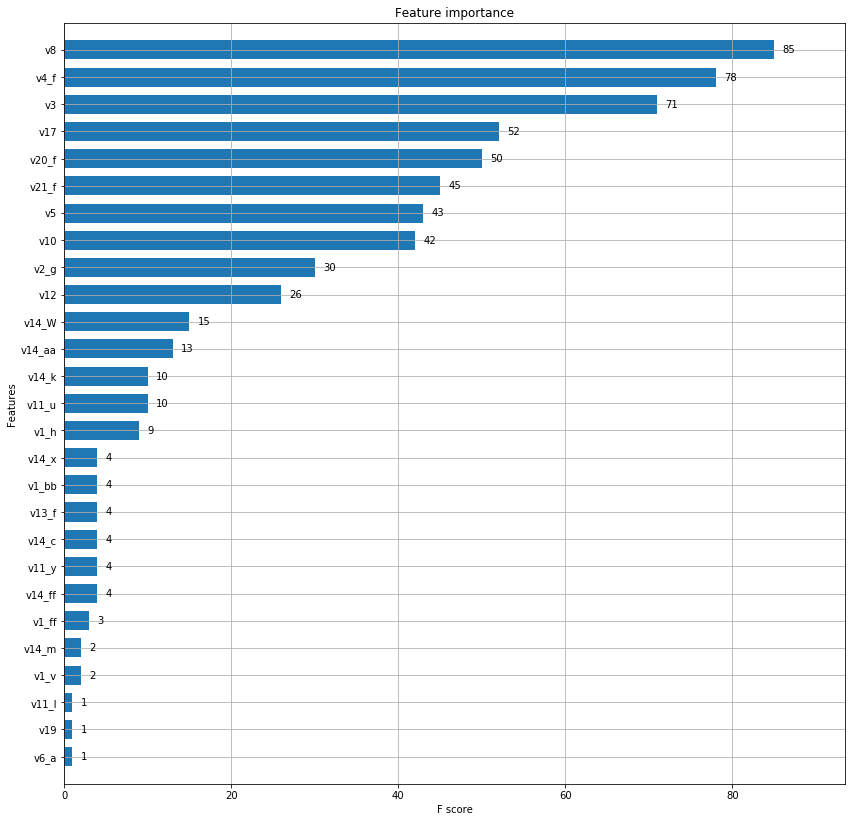

In [57]:
# Plotting variable importance

fig, ax = plt.subplots(figsize=(14, 14))
plot_importance(model, ax = ax, height=0.7)
plt.show()


Thus, the 5 most important predictors in the model are:
- `v8` with a score of 85
- `v4_f` with a score of 78
- `v3` with a score of 71
- `v17` with a score of 52
- `v20_f` with a score of 50

In [58]:
# Fit model using each importance as a threshold

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    

Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.000, n=51, Accuracy: 97.58%
Thresh=0.002, n=27, Accuracy: 97.58%
Thresh=0.002, n=27, Accuracy: 97.58%
Thresh=0.002, n=27, Accuracy: 97.58%
T

In conclusion, we notice that when we keep 24 components the model accuracy actually increases by 0.09% to 97.67%. Therefore, it is definitely advisable to rebuild the model with the 24 principal components as it will reduce computation time and slightly increase the overall accuracy.